In [1]:
%pip install -qU PyMuPDF pillow langchain-openai

Note: you may need to restart the kernel to use updated packages.


## Create a function to export PDF page to PNG image file

In [2]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

## Load the PDF document, convert specified page number to image, display the image

In [10]:
file_path = "../sample_data/chart_notes/B3WLYLU9 No PHI.pdf"

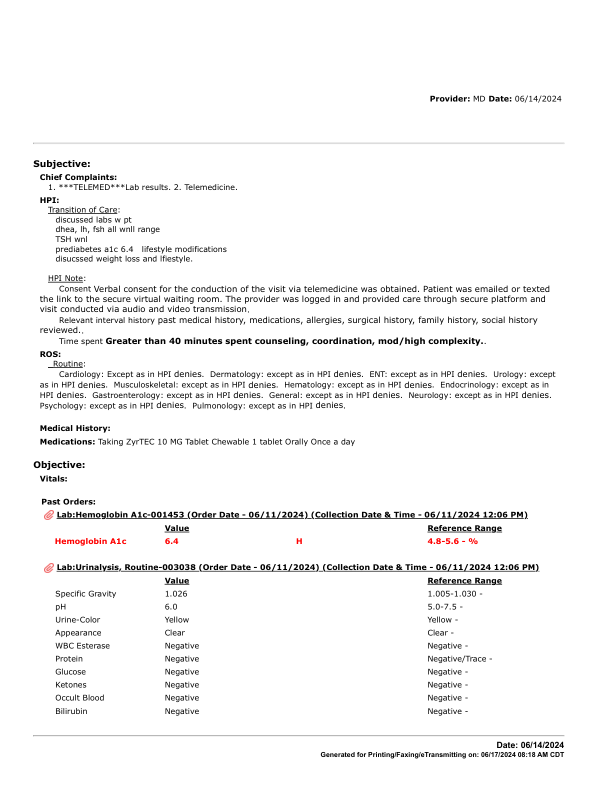

In [11]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64(file_path, 1)
display(IPImage(data=base64.b64decode(base64_image)))

## Setup LLM model

In [7]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}=")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("OPENAI_API_BASE_URL")

In [8]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(model="chat", api_version="2024-02-15-preview", base_url=os.environ["OPENAI_API_BASE_URL"])

## Send image bytes to model for reasoning

In [13]:
from langchain_core.messages import HumanMessage

query = "What is the patient's ketones value?"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

The patient's ketones value is "Negative".
